#### Author: Papiya Sen

#### Project: predict savings from US Census data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

columns = ["age", "worker_class", "industry_cd", "occupation_cd",
           "education", "wage_per_hour", "enrolled",
           "marital_status", "major_industry_cd", "major_occupation_cd",
           "race", "hispanic", "sex", "union_member", "unempl_reason",
           "ft_pt_empl_stat", "cap_gains", "cap_loss", "dividends",
           "tax_filer_status", "region_prev_res", "state_prev_res",
           "hhold_fam_stat", "hhold_summary", "instance_weight", "msa_change",
           "reg_change", "reg_within", "live_1_year", "sunbelt",
           "num_worked_for_employer", "num_under_18", 
           "cntry_birth_father", "cntry_birth_mother", "cntry_birth_self",
           "citizenship", "own_biz_self", "veterans_questions",
           "veterans_benefits", "weeks_worked", "year", "income"]

# load training data with assigned column names
df = pd.read_csv('./census_income_learn.csv', names = columns)

# drop column: "instance_weight" from df before building the model
df = df.drop('instance_weight', 1)

# convert "income" into boolean variable: '- 50000.' = 0, '50000+.' = 1
df['income'] = df['income'].apply(lambda x: 0 if '- 50000.' in x else 1)

# build lists for continuous and nominal variables
all_vars = [i for i in range(len(df.columns))]
continuous_vars = [0, 5, 16, 17, 18, 29, 38]
nominal_vars = list(set(all_vars) - set(continuous_vars))
# print(nominal_vars)
# print('number of columns in df = ', len(df.columns))
# print(df.tail())

# move response variable (last column) to new dataframe
dfY = df.ix[:, 'income']

df_plus = df.loc[df['income'] == 1]  # saving profiles when savings > 50,000
df_minus = df.loc[df['income'] == 0]  # saving profiles when savings < 50,000

# drop response variable, keep only the features 
df.drop(['income'],inplace=True,axis=1)

# making copy for later use
df2 = df




In [13]:
# Getting statistics on the above continuous variables
C_names = []
L = []
for i in continuous_vars:
    if i > 23:
        i = i + 1
    x = columns[i]
    l = df[x].describe().tolist()
    L.append(l)
    C_names.append(x)
L = np.asarray(L)

# print statistics for all continuous variables
df_stats = pd.DataFrame(L)
df_stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df_stats['Variables'] = C_names
indexed_df = df_stats.set_index(['Variables'])
print(indexed_df)


,count,mean,std,min,25%,50%,75%,max
Variables,,,,,,,,
age,199523.0,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
wage_per_hour,199523.0,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
cap_gains,199523.0,434.718990,4697.531280,0.0,0.0,0.0,0.0,99999.0
cap_loss,199523.0,37.313788,271.896428,0.0,0.0,0.0,0.0,4608.0
dividends,199523.0,197.529533,1984.163658,0.0,0.0,0.0,0.0,99999.0
num_worked_for_employer,199523.0,1.956180,2.365126,0.0,0.0,1.0,4.0,6.0
weeks_worked,199523.0,23.174897,24.411488,0.0,0.0,8.0,52.0,52.0


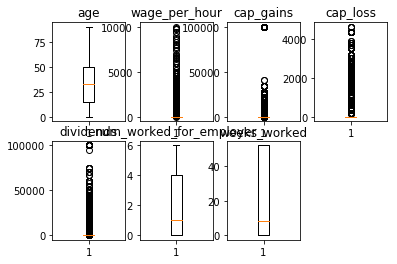

In [3]:
# Box-plots of continuous variables
for i in range(len(continuous_vars)):
    plt.subplot(2,4,i+1)
    x = continuous_vars[i]
    if x > 23:
        x = x + 1    
    plt.boxplot(df[columns[x]])
    plt.title(columns[x])
plt.show()


The above boxplots and statistics indicate a few things:
1. Mean is zero for the variables 'wage per hour', 'cap gains', 'cap losses' and 'dividends'
2. Average age is 33, and as age increases savings are higher. This is as expected.
3. Average weeks worked per year is 8. As weeks worked increase, savings increase , which is as expected.

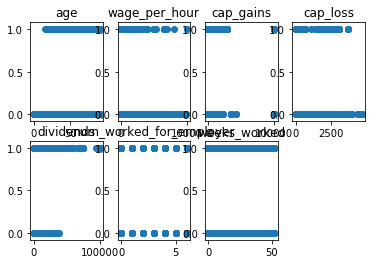

In [4]:
# visualize effect of continuous features on response

for i in range(len(continuous_vars)):
    plt.subplot(2,4,i+1)
    x = continuous_vars[i]
    if x > 23:
        x = x + 1
    plt.scatter(df[columns[x]], dfY)
    plt.title(columns[x])
plt.show() 

From above plots:

'age' plot: when age is small, there is less savings, which is intuitive. Hence, age is a variable to keep.

In 'wage per hour' plot, when wage increases, we do not get higher savings. This is counter-intuitive. This may be due to a different factor reducing the effect of higher wages.

'dividends' after a threshold does positively affect the savings.

'# family members < 18' does not appear to have an effect on savings

'weeks worked per year' does positively affect savings 

In [6]:
# check for missing values
print(np.where(pd.isnull(df)))

# check for illogical values
print(df[columns[21]].unique()) # check all columns for missing values

(array([], dtype=int64), array([], dtype=int64))
[' Not in universe' ' Arkansas' ' Utah' ' Michigan' ' Minnesota' ' Alaska'
 ' Kansas' ' Indiana' ' ?' ' Massachusetts' ' New Mexico' ' Nevada'
 ' Tennessee' ' Colorado' ' Abroad' ' Kentucky' ' California' ' Arizona'
 ' North Carolina' ' Connecticut' ' Florida' ' Vermont' ' Maryland'
 ' Oklahoma' ' Oregon' ' Ohio' ' South Carolina' ' Texas' ' Montana'
 ' Wyoming' ' Georgia' ' Pennsylvania' ' Iowa' ' New Hampshire' ' Missouri'
 ' Alabama' ' North Dakota' ' New Jersey' ' Louisiana' ' West Virginia'
 ' Delaware' ' Illinois' ' Maine' ' Wisconsin' ' New York' ' Idaho'
 ' District of Columbia' ' South Dakota' ' Nebraska' ' Virginia'
 ' Mississippi']


In [ ]:
# replacing "?" in dataframe with string "missing"
df.replace(' ?', ' Missing', inplace=True)


From above:

There are no empty cells in the dataframe



#### CLASSIFIERS

In [8]:
# Preprocessing nominal columns
from sklearn import preprocessing
for index in nominal_vars:
    if index < 40:
        le = preprocessing.LabelEncoder()
        if index > 23:
            index = index + 1
        print(index, columns[index])    
        df[columns[index]] = le.fit_transform(df[columns[index]])
        
# cross validation
from sklearn.cross_validation import cross_val_score
n_folds = 5       
        

1 worker_class
2 industry_cd
3 occupation_cd
4 education
6 enrolled
7 marital_status
8 major_industry_cd
9 major_occupation_cd
10 race
11 hispanic
12 sex
13 union_member
14 unempl_reason
15 ft_pt_empl_stat
19 tax_filer_status
20 region_prev_res
21 state_prev_res
22 hhold_fam_stat
23 hhold_summary
25 msa_change
26 reg_change
27 reg_within
28 live_1_year
29 sunbelt
31 num_under_18
32 cntry_birth_father
33 cntry_birth_mother
34 cntry_birth_self
35 citizenship
36 own_biz_self
37 veterans_questions
38 veterans_benefits
40 year


/Users/papiyasen/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Find best Classifier with cross-validation using 'f1 score' metrics 

In [9]:
# testing different classifiers - Logistic Regression, Decision Tree, Random Forest
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# evaluate Logistic Regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
print("Five-fold cross validation F1 score mean for LR is ", cross_val_score(lr, df, dfY, cv = n_folds, scoring='f1').mean())

# evaluate Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10)
print("Five-fold cross validation F1 score mean for DT is ", cross_val_score(dt, df, dfY, cv = n_folds, scoring='f1').mean())

# evaluate Random Forest classifier (RFC)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', max_depth=15)
print("Five-fold cross validation F1 score mean for RFC is ", cross_val_score(rfc, df, dfY, cv = n_folds, scoring='f1').mean())




Five-fold cross validation F1 score mean for LR is  0.388509667896
Five-fold cross validation F1 score mean for DT is  0.437773423604
Five-fold cross validation F1 score mean for RFC is  0.452347487726


depth is 20
depth is 21
depth is 22
depth is 23
depth is 24
depth is 25


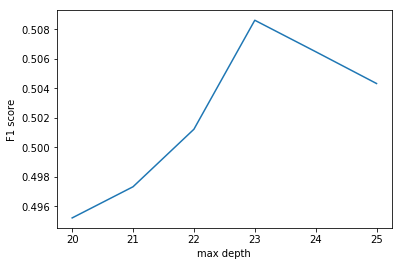

In [95]:
# better F1-score is achieved with RFC compared to Logistic Regression and Decision Tree
# finding best parameter for RFC
depth_range = range(8, 26)
d_scores = []
for d in depth_range:
    print("depth is %d" %d)
    rfc = RandomForestClassifier(criterion='entropy', max_depth=d)
    score = cross_val_score(rfc, df, dfY, cv = n_folds, scoring='f1').mean()
    d_scores.append(score)

plt.plot(depth_range, d_scores)
plt.xlabel("max depth")
plt.ylabel("F1 score")
plt.show()

Best F1 score is when depth = 23. We choose this parameter value for our Randon forest classifier.

In [11]:
# Fit RFC model of depth = 23 to the entire dataset 
rfc_new = RandomForestClassifier(criterion='entropy', max_depth=23)
rfcm_new = rfc_new.fit(df, dfY)
score = cross_val_score(rfcm_new, df, dfY, cv = n_folds, scoring='f1').mean()
print("Training F1 score for RFC is ", score)

F1 score for RFC is  0.50664026205


In [12]:
## prediction using RFC model

df_test = pd.read_csv('./census_income_test.csv', names = columns)
df_test = df_test.drop('instance_weight', 1)
df_test['income'] = df_test['income'].apply(lambda x: 0 if '- 50000.' in x else 1)

dfY_test = df_test.ix[:, 'income']
df_test.drop(['income'],inplace=True,axis=1)

# preprocessing test data
for index in nominal_vars:
    if index < 40:
        le = preprocessing.LabelEncoder()
        if index > 23:
            index = index + 1
        #print(index, columns[index])    
        df_test[columns[index]] = le.fit_transform(df_test[columns[index]])
        
# calculate f1 score for test data
print("Test F1 score for RFC is ",f1_score(dfY_test, rfcm_new.predict(df_test)))


Test F1 score for RFC is  0.456048341124


In [19]:
# find features that affect  savings > 50000

# Getting statistics on the continuous variables
Cplus_names = []
Lplus = []
for i in continuous_vars:
    if i > 23:
        i = i + 1
    x = columns[i]
    l = df_plus[x].describe().tolist()
    Lplus.append(l)
    Cplus_names.append(x)
Lplus = np.asarray(Lplus)

# print statistics for all continuous variables
df_plus_stats = pd.DataFrame(Lplus)
df_plus_stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df_plus_stats['Variables'] = Cplus_names
indexed_df_plus = df_plus_stats.set_index(['Variables'])
print(indexed_df_plus)

,count,mean,std,min,25%,50%,75%,max
Variables,,,,,,,,
age,12382.0,46.266193,11.830906,16.0,38.0,45.0,53.0,90.0
wage_per_hour,12382.0,81.640284,431.364773,0.0,0.0,0.0,0.0,9999.0
cap_gains,12382.0,4830.930060,16887.627002,0.0,0.0,0.0,0.0,99999.0
cap_loss,12382.0,193.139557,607.542507,0.0,0.0,0.0,0.0,3683.0
dividends,12382.0,1553.448070,6998.071762,0.0,0.0,0.0,363.0,99999.0
num_worked_for_employer,12382.0,4.003715,2.118183,0.0,2.0,4.0,6.0,6.0
weeks_worked,12382.0,48.069617,12.259412,0.0,52.0,52.0,52.0,52.0


[(' Married-civilian spouse present', 9600), (' Never married', 1117), (' Divorced', 1066)]


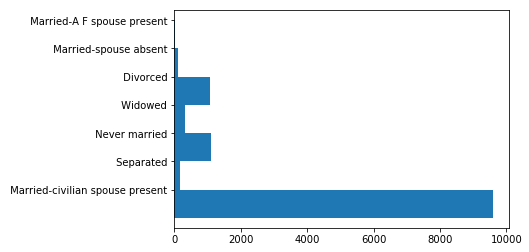

In [40]:
# check nominal variables affecting savongs > 50,000

from collections import Counter

# print top 3 categories in 'education'
print(Counter(df_plus['marital_status']).most_common(3))


labels, values = zip(*Counter(df_plus['marital_status']).items())

indexes = np.arange(len(labels))
width = 1
plt.barh(indexes, values, width)
plt.yticks(indexes + width * 0.5, labels)
plt.show()
